### Assessment 6
***GitHub Link:*** https://github.com/manansuthar55/CSE6037_20MAI0016/tree/main/Assessment_6
#### Problem : Encoder Decoder

## Encoder Decoder translation model using LSTM with Python and Keras
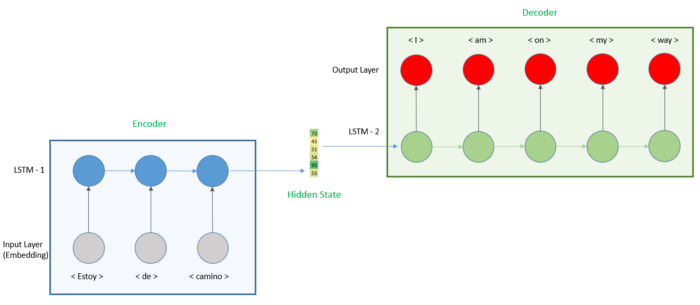

In [1]:
import string
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

# Path to translation file
path_to_data = '/content/drive/MyDrive/Colab Notebooks/DL_LAB_6/spa.txt'

# Read file
translation_file = open(path_to_data,"r", encoding='utf-8') 
raw_data = translation_file.read()
translation_file.close()

# Parse data
raw_data = raw_data.split('\n')
pairs = [sentence.split('\t') for sentence in  raw_data]
pairs = pairs[1000:20000]

In [2]:
def clean_sentence(sentence):
    # Lower case the sentence
    lower_case_sent = sentence.lower()
    # Strip punctuation
    string_punctuation = string.punctuation + "¡" + '¿'
    clean_sentence = lower_case_sent.translate(str.maketrans('', '', string_punctuation))
   
    return clean_sentence

In [3]:
def tokenize(sentences):
    # Create tokenizer
    text_tokenizer = Tokenizer()
    # Fit texts
    text_tokenizer.fit_on_texts(sentences)
    return text_tokenizer.texts_to_sequences(sentences), text_tokenizer

In [4]:
english_sentences = [clean_sentence(pair[0]) for pair in pairs]
spanish_sentences = [clean_sentence(pair[1]) for pair in pairs]

# Tokenize words
spa_text_tokenized, spa_text_tokenizer = tokenize(spanish_sentences)
eng_text_tokenized, eng_text_tokenizer = tokenize(english_sentences)

print('Maximum length spanish sentence: {}'.format(len(max(spa_text_tokenized,key=len))))
print('Maximum length english sentence: {}'.format(len(max(eng_text_tokenized,key=len))))


# Check language length
spanish_vocab = len(spa_text_tokenizer.word_index) + 1
english_vocab = len(eng_text_tokenizer.word_index) + 1
print("Spanish vocabulary is of {} unique words".format(spanish_vocab))
print("English vocabulary is of {} unique words".format(english_vocab))

Maximum length spanish sentence: 15
Maximum length english sentence: 6
Spanish vocabulary is of 7248 unique words
English vocabulary is of 3756 unique words


In [5]:
max_spanish_len = int(len(max(spa_text_tokenized,key=len)))
max_english_len = int(len(max(eng_text_tokenized,key=len)))

spa_pad_sentence = pad_sequences(spa_text_tokenized, max_spanish_len, padding = "post")
eng_pad_sentence = pad_sequences(eng_text_tokenized, max_english_len, padding = "post")

# Reshape data
spa_pad_sentence = spa_pad_sentence.reshape(*spa_pad_sentence.shape, 1)
eng_pad_sentence = eng_pad_sentence.reshape(*eng_pad_sentence.shape, 1)

## Encoder
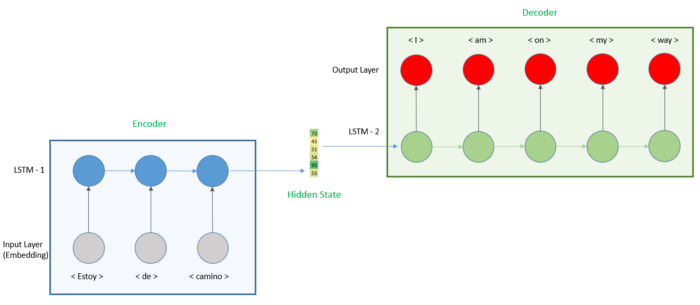

## Decoder
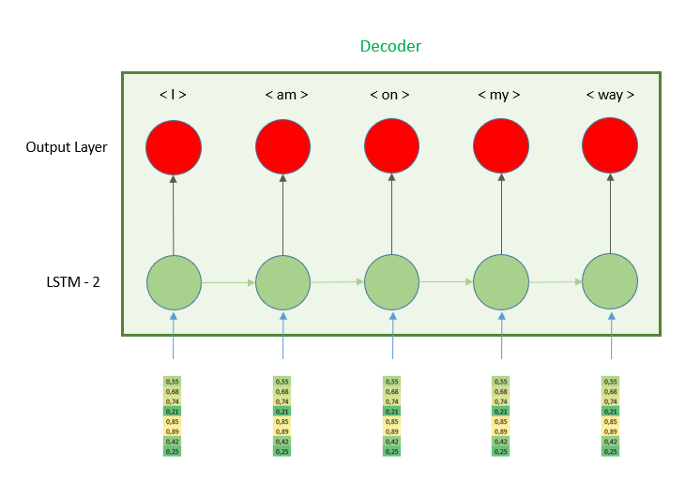

In [6]:
input_sequence = Input(shape=(max_spanish_len,))
embedding = Embedding(input_dim=spanish_vocab, output_dim=128,)(input_sequence)
encoder = LSTM(64, return_sequences=False)(embedding)
r_vec = RepeatVector(max_english_len)(encoder)
decoder = LSTM(64, return_sequences=True, dropout=0.2)(r_vec)
logits = TimeDistributed(Dense(english_vocab))(decoder)

In [7]:
enc_dec_model = Model(input_sequence, Activation('softmax')(logits))
enc_dec_model.compile(loss=sparse_categorical_crossentropy,
              optimizer=Adam(1e-3),
              metrics=['accuracy'])
enc_dec_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           927744    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 6, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
time_distributed (TimeDistri (None, 6, 3756)           244140    
_________________________________________________________________
activation (Activation)      (None, 6, 3756)           0     

In [8]:
model_results = enc_dec_model.fit(spa_pad_sentence, eng_pad_sentence, batch_size=30, epochs=100)

Epoch 1/100
634/634 [==============================] - 37s 53ms/step - loss: 4.7491 - accuracy: 0.4344
Epoch 2/100
634/634 [==============================] - 32s 50ms/step - loss: 3.4452 - accuracy: 0.4782
Epoch 3/100
634/634 [==============================] - 30s 48ms/step - loss: 3.3563 - accuracy: 0.4806
Epoch 4/100
634/634 [==============================] - 30s 47ms/step - loss: 3.3181 - accuracy: 0.4815
Epoch 5/100
634/634 [==============================] - 31s 50ms/step - loss: 3.3074 - accuracy: 0.4798
Epoch 6/100
634/634 [==============================] - 30s 48ms/step - loss: 3.3437 - accuracy: 0.4784
Epoch 7/100
634/634 [==============================] - 31s 48ms/step - loss: 3.3204 - accuracy: 0.4787
Epoch 8/100
634/634 [==============================] - 31s 49ms/step - loss: 3.2840 - accuracy: 0.4800
Epoch 9/100
634/634 [==============================] - 31s 49ms/step - loss: 3.2803 - accuracy: 0.4790
Epoch 10/100
634/634 [==============================] - 34s 53ms/step - l

In [9]:
def logits_to_sentence(logits, tokenizer):
    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

index = 14
print("The english sentence is: {}".format(english_sentences[index]))
print("The spanish sentence is: {}".format(spanish_sentences[index]))
print('The predicted sentence is :')
print(logits_to_sentence(enc_dec_model.predict(spa_pad_sentence[index:index+1])[0], eng_text_tokenizer))

The english sentence is: whats up
The spanish sentence is: qué hay
The predicted sentence is :
whats is <empty> <empty> <empty> <empty>
